In [360]:
from collections import defaultdict
import functools
import io
import os
import os.path as osp

from attrdict import AttrDict

import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
% matplotlib inline

from PIL import Image
import IPython.display as display









In [93]:
def parse_object(obj):
    id = int(obj[0].text)
    x2, x1, y2, y1 = (int(i.text) for i in obj[2])
    bbox = np.asarray([y1, x1, y2 - y1, x2 - x1])

    return id, dict(name=obj[1].text, bbox=bbox, occluded=int(obj[3].text), generated=int(obj[4].text))


def parse_label(label_path):
    root = ElementTree.parse(label_path).getroot()

    folder = root[0].text
    filename = root[1].text
    size = tuple(int(i.text) for i in reversed(root[3]))

    obj_by_id = dict()
    objects = root[4:]
    for obj in objects:
        id, obj = parse_object(obj)
        obj_by_id[id] = obj

    return folder, filename, size, obj_by_id


def find_xmls(path):
    xmls = sorted([p for p in os.listdir(path) if p.endswith('.xml')])
    return [os.path.join(path, xml) for xml in xmls]


def parse_label_seq(seq_path, fixed_size=None):
    xmls = find_xmls(seq_path)

    obj_by_id = dict()
    imgs_by_folder = defaultdict(list)

    for p in xmls:
        folder, filename, size, by_id = parse_label(p)

        if fixed_size:

            # fixed_aspect_ratio = float(fixed_size[0]) / fixed_size[1]
            # aspect_ratio = float(size[0]) / size[1]
            # assert (fixed_aspect_ratio > 1.) == (aspect_ratio > 1.), 'Invalid aspect ratio: {} vs {}'.format(fixed_aspect_ratio, aspect_ratio)

            size_ratio = np.asarray(fixed_size).astype(np.float32) / np.asarray(size)
            size_ratio = np.tile(size_ratio, (2,))
            size = fixed_size
        else:
            size_ratio = 1.

        imgs_by_folder[folder].append(dict(filename=filename, size=size))

        for i, obj in by_id.iteritems():

            if i not in obj_by_id:
                obj_by_id[i] = AttrDict()
                obj_by_id[i].id = i
                obj_by_id[i].name = obj['name']
                obj_by_id[i]['boxes'] = []

            obj = AttrDict(obj)
            del obj['name']
            obj.bbox = obj.bbox * size_ratio
            obj.frame_num = int(filename)
            obj_by_id[i]['boxes'].append(obj)


    return imgs_by_folder, obj_by_id

In [211]:
def extract_files(filedict):

    files = []
    dirnames = sorted(filedict.keys(), key=lambda x: int(x.split('_')[-1]))
    for dirname in dirnames:
        filelist = filedict[dirname]
        filelist = [d['filename'] for d in filelist]
        filelist = sorted(filelist, key=lambda x: int(x.split('.')[0]))
        for f in filelist:
            files.append(osp.join(dirname, f) + '.JPEG')

    return files

In [201]:
def extract_properties(properties):

    obj_boxes = aseq[1][0].boxes
    n_obj = len(aseq[1])
    num_frames = sum(len(elem) for elem in aseq[0].values())
    print n_obj, num_frames

    obj_to_idx = dict(zip(aseq[1].keys(), range(n_obj)))

    boxes = np.zeros([num_frames, n_obj, 4], dtype=np.float32)
    generated = np.zeros([num_frames, n_obj, 1], dtype=np.uint8)
    occluded = np.zeros([num_frames, n_obj, 1], dtype=np.uint8)
    presence = np.zeros([num_frames, n_obj, 1], dtype=np.uint8)


    for obj_id in aseq[1].keys():
        obj_idx = obj_to_idx[obj_id]
        for box in aseq[1][obj_id].boxes:
            frame_num = box.frame_num
            boxes[frame_num, obj_idx, :] = box.bbox
            generated[frame_num, obj_idx] = box.generated
            occluded[frame_num, obj_idx] = box.occluded
            presence[frame_num, obj_idx] = 1
        
    return AttrDict(boxes=boxes, generated=generated, occluded=occluded,
                    presence=presence, n_obj=n_obj)



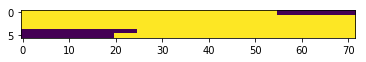

In [187]:
def parse(sequence_file, root_dir=None, seq_filter=None):
    parsed_seqs = []
    for line in open(seq_file).readlines()[len(parsed_seqs):]:
        dirname = os.path.dirname(line.strip())
        if root_dir is not None:
            dirname = osp.join(root_dir, dirname)
            
        parsed_seqs.append(parse_label_seq(dirname))
        
    parsed_seqs = np.asarray(parsed_seqs)
    if seq_filter is not None:
        parsed_seqs = seq_filter(parsed_seqs)
        
    seq_properties = []
    for parsed_seq in parsed_seqs:
        properties = extract_properties(parsed_seq[1])
        properties.img_files = extract_files(parsed_seq[0], root_dir)
        seq_properties.append(properties)
        
    return np.asarray(seq_properties)

In [316]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature_list(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [324]:
def read_img_as_bytes(path):
    buffer = io.BytesIO()
    Image.open(path).save(buffer, format='JPEG')
    return buffer.getvalue()


def video_example(properties):
    
    img_files = list(properties.img_files)
    
    root = '/Users/adam/data/ILSVRC2015_VID/Data/VID/train'
    img_files = [osp.join(root, f) for f in img_files]
    
    img = np.asarray(Image.open(img_files[0]))
    img_string = [open(f, 'rb').read() for f in img_files]
#     img_string = [read_img_as_bytes(f) for f in img_files]
            
    feature = {
        'height': _int64_feature(img.shape[0]),
        'width': _int64_feature(img.shape[1]),
        'depth': _int64_feature(img.shape[2]),
        'num_frames': _int64_feature(len(img_files)),
        'frames_raw': _bytes_feature_list(img_string),
        'n_obj': _int64_feature(properties.n_obj)
    }
    
    for k in 'boxes generated occluded presence'.split():
        feature[k] = _bytes_feature_list(properties[k].tobytes())

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [130]:
# parsed_seqs = []
seq_file = '/Users/adam/data/ILSVRC2015_VID/Annotations/VID/seqs.txt'
root_dir = '/Users/adam/data/ILSVRC2015_VID/Annotations/VID'

for line in open(seq_file).readlines()[len(parsed_seqs):]:
    dirname = os.path.dirname(line.strip())
    dirname = osp.join(root_dir, dirname)
    parsed_seqs.append(parse_label_seq(dirname))

print len(parsed_seqs)

In [132]:
n_objs = []
avg_frames_per_obj = []
for parsed_seq in parsed_seqs:
    n_objs.append(len(parsed_seq[1].keys()))
    avg_frames_per_obj.append(sum([len(parsed_seq[1][k].boxes) for k in parsed_seq[1]]) / float(n_objs[-1]))
    
n_objs = np.asarray(n_objs)
avg_frames_per_obj = np.asarray(avg_frames_per_obj)

In [133]:
print len(parsed_seqs), len(n_objs)

4417 4417


In [134]:
min(n_objs), np.mean(n_objs), max(n_objs)

(1, 2.0873896309712476, 47)

In [135]:
min(avg_frames_per_obj), np.mean(avg_frames_per_obj), max(avg_frames_per_obj)

(6.0, 247.28245524147604, 3597.0)

In [146]:
mask = np.logical_and(n_objs>=5, n_objs<=100)
print n_objs[mask].size
print avg_frames_per_obj[mask].sum()

363
58526.43813493292


In [148]:
aseq = np.asarray(parsed_seqs)[mask][0]

In [33]:
my_root_dir = root_dir + 'ILSVRC2015_VID_train_0000/'
label_dir, img_dir, seq_names = find_sequences(my_root_dir)

In [34]:
label_dir, img_dir, len(seq_names)

('/Users/adam/data/ILSVRC2015_VID/Data/VID/train/ILSVRC2015_VID_train_0000/',
 '/Users/adam/data/ILSVRC2015_VID/Data/VID/train/ILSVRC2015_VID_train_0000/',
 1000)

In [40]:
xmls = find_xmls(folder)

In [44]:
label = parse_label(xmls[0])

In [212]:
properties = extract_properties(aseq[1])
properties.img_files = extract_files(aseq[0])

6 72


In [319]:
properties.boxes.shape

(72, 6, 4)

In [3]:
vid_folder = '/Users/adam/data/ILSVRC2015_VID/Data/VID/val/ILSVRC2015_val_00008001'

In [4]:
img_files = [os.path.join(vid_folder, f) for f in os.listdir(vid_folder) if osp.splitext(f)[-1] == '.JPEG']
img_files = sorted(img_files)



In [325]:
img_example = video_example(properties)

In [326]:
img_example_string = img_example.SerializeToString()

In [327]:
print len(img_example_string)
len(open(img_files[0], 'rb').read())

16968914


20876

In [328]:
with tf.python_io.TFRecordWriter('images.tfrecords') as writer:
    writer.write(img_example_string)

In [329]:
!ls

images.tfrecords  imagnet_vid.ipynb


In [351]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.  
image_feature_description = {
    'height': tf.FixedLenFeature([], tf.int64),
    'width': tf.FixedLenFeature([], tf.int64),
    'depth': tf.FixedLenFeature([], tf.int64),
    'num_frames': tf.FixedLenFeature([], tf.int64),
    'frames_raw': tf.VarLenFeature(tf.string),
    'n_obj': tf.FixedLenFeature([], tf.int64),
    'boxes': tf.VarLenFeature(tf.string),
    'generated': tf.VarLenFeature(tf.string),
    'occluded': tf.VarLenFeature(tf.string),
    'presence': tf.VarLenFeature(tf.string),
}

# SEQ_NUM_FRAMES = 100
# EVERY_N_FRAMES = 2
# shape = (SEQ_NUM_FRAMES / EVERY_N_FRAMES, 360, 540, 3)

shape = (None, 1080, 1920, 3)
MAX_N_OBJECTS = 30


def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    d = tf.parse_single_example(example_proto, image_feature_description)
    
#     def map_func(idx):
#         return tf.io.decode_jpeg(d['frames_raw'].values[idx])
    
#     random_offset = tf.random_uniform(
#         shape=(), minval=0,
#         maxval=d['num_frames'] - SEQ_NUM_FRAMES, dtype=tf.int64)

#     offsets = tf.range(random_offset, random_offset + SEQ_NUM_FRAMES, EVERY_N_FRAMES)
    
#     img = tf.map_fn(map_func, offsets, dtype=tf.uint8)
    
    img = tf.map_fn(tf.io.decode_jpeg, d['frames_raw'].values, dtype=tf.uint8)
    img.set_shape(shape)
    d['frames'] = img
    del d['frames_raw']
    
    n_obj = d['n_obj']
    num_frames = d['num_frames']
    _shape = [num_frames, n_obj]
    
    # different sequences will have different number of objects;
    # here we make sure that they are padded accordingly
    n_pads = MAX_N_OBJECTS - n_obj
    
    def _decode(name, dtype, n_elems):
        encoded = d[name].values
        
        # tensor consists of strings of length 1, but we need 4 bytes for a float32
        # we need to merge 4 strings into one along the last axis
        if dtype == tf.float32:
            encoded = tf.reshape(encoded, [-1, 4])
            encoded = tf.unstack(encoded, axis=-1)
            encoded = tf.strings.join(encoded)
        
        decoded = tf.reshape(tf.decode_raw(encoded, dtype), _shape + [n_elems])
        decoded = tf.pad(decoded, [(0, 0), (0, n_pads), (0, 0)])
        d[name] = decoded
    
    _decode('occluded', tf.uint8, 1)
    _decode('generated', tf.uint8, 1)
    _decode('presence', tf.uint8, 1)
    _decode('boxes', tf.float32, 4)
    
    return d

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

before Tensor("ParseSingleExample/ParseSingleExample:5", shape=(?,), dtype=string)
after Tensor("StringJoin:0", shape=(?,), dtype=string)
<DatasetV1Adapter shapes: {occluded: (?, ?, 1), presence: (?, ?, 1), num_frames: (), boxes: (?, ?, 4), height: (), width: (), depth: (), frames: (?, 1080, 1920, 3), n_obj: (), generated: (?, ?, 1)}, types: {occluded: tf.uint8, presence: tf.uint8, num_frames: tf.int64, boxes: tf.float32, height: tf.int64, width: tf.int64, depth: tf.int64, frames: tf.uint8, n_obj: tf.int64, generated: tf.uint8}>


In [352]:
it = parsed_image_dataset.repeat().make_one_shot_iterator()

In [353]:
batch = it.get_next()

In [354]:
batch

{'boxes': <tf.Tensor 'IteratorGetNext_14:0' shape=(?, ?, 4) dtype=float32>,
 'depth': <tf.Tensor 'IteratorGetNext_14:1' shape=() dtype=int64>,
 'frames': <tf.Tensor 'IteratorGetNext_14:2' shape=(?, 1080, 1920, 3) dtype=uint8>,
 'generated': <tf.Tensor 'IteratorGetNext_14:3' shape=(?, ?, 1) dtype=uint8>,
 'height': <tf.Tensor 'IteratorGetNext_14:4' shape=() dtype=int64>,
 'n_obj': <tf.Tensor 'IteratorGetNext_14:5' shape=() dtype=int64>,
 'num_frames': <tf.Tensor 'IteratorGetNext_14:6' shape=() dtype=int64>,
 'occluded': <tf.Tensor 'IteratorGetNext_14:7' shape=(?, ?, 1) dtype=uint8>,
 'presence': <tf.Tensor 'IteratorGetNext_14:8' shape=(?, ?, 1) dtype=uint8>,
 'width': <tf.Tensor 'IteratorGetNext_14:9' shape=() dtype=int64>}

In [355]:
sess = tf.Session()

In [356]:
res = sess.run(batch)

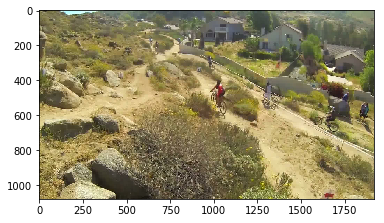

In [357]:
plt.imshow(res['frames'][-1])

In [358]:
list(res['boxes'])

[array([[ 221.,  629.,   43.,   27.],
        [ 365.,  890.,   96.,   59.],
        [ 330., 1029.,   70.,   59.],
        [ 541., 1405.,   96.,  136.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   

In [359]:
properties.boxes

array([[[ 221.,  629.,   43.,   27.],
        [ 365.,  890.,   96.,   59.],
        [ 330., 1029.,   70.,   59.],
        [ 541., 1405.,   96.,  136.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       [[ 222.,  634.,   43.,   27.],
        [ 365.,  892.,   92.,   59.],
        [ 334., 1032.,   69.,   58.],
        [ 542., 1406.,   96.,  135.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       [[ 223.,  639.,   43.,   28.],
        [ 365.,  894.,   89.,   59.],
        [ 338., 1035.,   68.,   58.],
        [ 544., 1408.,   96.,  133.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.]],

       ...,

       [[   0.,    0.,    0.,    0.],
        [ 213.,  666.,   48.,   30.],
        [ 285.,  973.,   52.,   45.],
        [ 462., 1287.,   87.,   99.],
        [ 457.,  998.,  155.,   97.],
        [ 573., 1578.,  131.,  148.]],

       [[   0.,    0.,    0.,    0.],
        [ 213.,  666.,   48.,